## ResNet50 with 256X256 images

In [2]:
#imports
import os
import random
import shutil

from pathlib import Path
import urllib

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *

import warnings
warnings.filterwarnings('ignore')

## Prepare Data Frame

In [3]:
path = Path('../input/food-101/food-101/food-101')
path_meta = path/'meta'
path_images = path/'images'

In [4]:
def build_data_frame(path_name, file_name, img_format = 'jpg'):
    """
    build_data_frame input the path and file name, the function will return the dataframe with two columns:
    ['label'] : image label
    ['image_file'] : image file name with directory information
    input paramters:
    path_name : path 
    file_name : file name, string
    img_format : default format is jpg
    
    return dataframe
    """
    path_file = path_name/file_name
    file_df = pd.read_csv(path_file,delimiter='/', header=None, names=['label', 'image_file'])
    file_df['image_file'] = file_df['label'].astype(str) + '/' + file_df['image_file'].astype(str) + '.'+img_format
    
    return file_df

In [5]:
train_df = build_data_frame(path_meta, 'train.txt')
test_df = build_data_frame(path_meta, 'test.txt')

## Data Augmentation

### Random Augmentation using Fastai [RandTransform class](https://docs.fast.ai/vision.image.html#RandTransform)
This class wraps Transform class to add randomized execution.
Each argument of func in kwargs is analyzed and if it has a type annotaiton that is a random function, this function will be called to pick a value for it. This value will be stored in the resolved dictionary. Following the same idea, p is the probability for func to be called and do_run will be set to True if it was the cause, False otherwise. Setting is_random to False allows to send specific values for each parameter. use_on_y is a parameter to further control transformations for targets (e.g. Segmentation Masks). Assuming transformations on labels are turned on using tfm_y=True (in your Data Blocks pipeline), use_on_y=False can disable the transformation for labels.

In [6]:
# Decorator for crop tfm functions, it crops the images but if the target size is bigger than the size of the image (on either dimension), padding is applied to padding_mode
# and the position of the center is ignored on that dimension
Crop_pads = RandTransform(tfm=TfmCrop(crop_pad),\
                       kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'padding_mode': 'reflection'}, \
                       p=1.0, \
                       resolved={}, \
                       do_run=True, \
                       is_random=True)

# Decorator for flip_affine function, it flip image horizontally.
Affine_flip = RandTransform(tfm=TfmAffine(flip_affine),\
                            kwargs={}, \
                            p=0.5, \
                            resolved={}, \
                            do_run=True, \
                            is_random=True)

# Decorator for symmetric_warp, which applies the four tilts at the same time, each with a strength given in the vector magnitude.
Coord_warp = RandTransform(tfm=TfmCoord(symmetric_warp), \
                           kwargs={'magnitude': (-0.2, 0.2)}, \
                           p=0.75, \
                           resolved={}, \
                           do_run=True, \
                           is_random=True)

#Decorator for rotate, which image by degrees
Affine_rotate = RandTransform(tfm=TfmAffine(rotate),\
                              kwargs={'degrees': (-20.0, 20.0)}, \
                              p=0.75, \
                              resolved={}, \
                              do_run=True, \
                              is_random=True)

#Decorator for zoom, which zoom image by scale. row_pct, col_pct select focal point of zoom
Affine_zoom = RandTransform(tfm=TfmAffine(zoom), \
                            kwargs={'scale': (1.0, 1.3), 'row_pct': (0, 1), 'col_pct': (0, 1)}, \
                            p=0.75, \
                            resolved={}, \
                            do_run=True, \
                            is_random=True)

#Decorator for brightness, which adjusts the brightness of the image depending on the value of change. A change of 0 will transform the image to black
#and a change of 1 will transform the image to white, change=0.5 doesn't adjust the brightness.
Lighting_brightness = RandTransform(tfm=TfmLighting(brightness), \
                         kwargs={'change': (0.4, 0.6)}, \
                         p=0.75, \
                         resolved={}, \
                         do_run=True, \
                         is_random=True)

#Decorator of contrast, which apply scale to constrast of image, a scale of 0 will transform the image to grey, and a scale of 1 will transform the picture 
#to super_contrast. scale=1 doesn't adjust the contrast.
Lighting_contrast = RandTransform(tfm=TfmLighting(contrast),\
                                  kwargs={'scale': (0.8, 1.25)}, \
                                  p=0.75, \
                                  resolved={}, \
                                  do_run=True,\
                                  is_random=True)

#Decorator of crop_pad, this is applied to validation set.
Crops = RandTransform(tfm=TfmCrop(crop_pad), \
                      kwargs={}, \
                      p=1.0, \
                      resolved={},\
                      do_run=True, \
                      is_random=True)

# Training Set Random Augmentation
train_tfms = [Crop_pads,Affine_flip,Coord_warp,Affine_rotate,Affine_zoom,Lighting_brightness,Lighting_contrast]

# validation set Random Augmentation
valid_tfms = [Crops]

random_tfms = (train_tfms,valid_tfms)

In [7]:
# batch size set to 64
bs = 64
train_data = (ImageList.from_df(df=train_df,path=path_images, cols=1)\
                            .split_by_rand_pct(0.2)\
                            .label_from_df(cols=0)\
                            .transform(random_tfms, size=256)\
                            .databunch(bs=bs)\
                            .normalize(imagenet_stats))

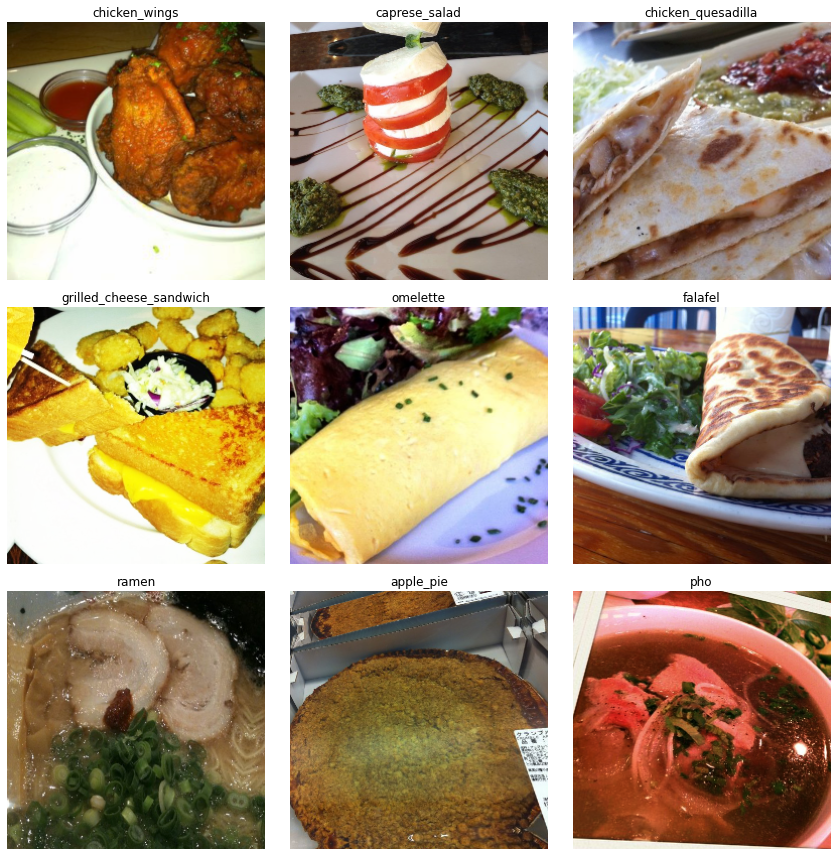

In [8]:
train_data.show_batch(rows=3, figsize=(12,12))

## Metrics Setup

Top-1 Accuracy and Top-5 accuracy are used to compare with the SoTA results

In [9]:
learn = cnn_learner(train_data, models.resnet50, metrics=[accuracy, partial(top_k_accuracy, k=5)], callback_fns=ShowGraph)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


## Model Structure

In [10]:
# show the structure of the whole ResNet50 Model
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256

## Learning Rate
Choosing a proper learning rate is crucial for deep network performance, a good learning rate can not only save runtime, but also help the model converge efficiently.
Let's train the model while changing the learning rate (increase), and plot the loss against learning rate.

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


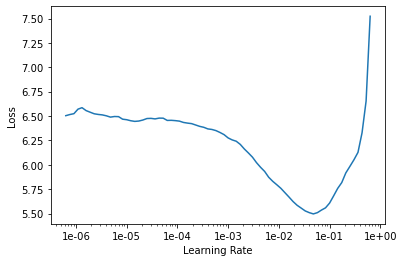

In [11]:
# First we need to change the output directory to the current working directory
learn.model_dir = os.getcwd()
learn.path = Path(os.getcwd())
# Finding a good learning rate
learn.lr_find()
learn.recorder.plot()

Fastai API let's you use dynamic lr during the modeling process, we can divide the training into 2 parts of a cycle, in the first part, we gradually increase learning rate to a maximum value, this can save a lot of computing time. As we are getting close to the loss minimum, we gradually decrease the learning rate in order not to overshoot  and explode the loss.

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,2.123019,1.619886,0.580330,0.834257,17:02
1,1.795610,1.444612,0.622178,0.863234,15:26
2,1.634046,1.311103,0.656172,0.877162,15:21
3,1.506758,1.206671,0.682376,0.892541,15:29
4,1.342463,1.145916,0.699802,0.900198,15:28
5,1.275134,1.056503,0.718020,0.910891,15:17
6,1.162833,0.980812,0.740330,0.919274,15:13
7,1.020199,0.940170,0.752013,0.923366,15:14
8,0.914848,0.918880,0.757426,0.924818,15:09
9,0.907018,0.913406,0.759406,0.924752,15:22


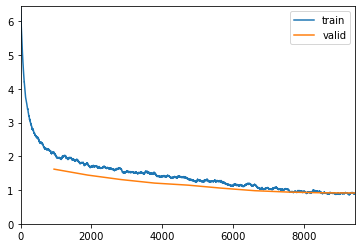

In [12]:
# we choose learning rate of 0.01 as it's at the point with the highest negative slope.
lr = 1e-2
learn.fit_one_cycle(10, slice(lr))
learn.save('food-101-ResNet50-v1')

## Unfreeze the Whole ResNet50 Model

In [14]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


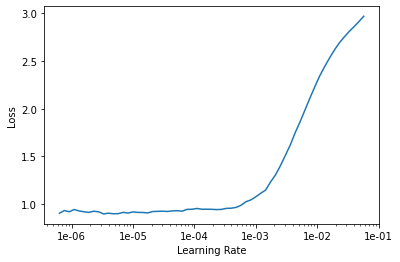

In [15]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.260613,1.241156,0.673267,0.887591,16:01
1,1.424922,1.295744,0.662376,0.878548,16:46
2,1.289105,1.131066,0.701056,0.900528,17:04
3,1.083835,0.993521,0.738482,0.916634,16:55
4,0.920499,0.881759,0.766667,0.931023,17:16
5,0.708081,0.771460,0.796634,0.942640,17:19
6,0.588214,0.723114,0.811089,0.948515,17:33
7,0.514530,0.712465,0.813993,0.949571,17:53


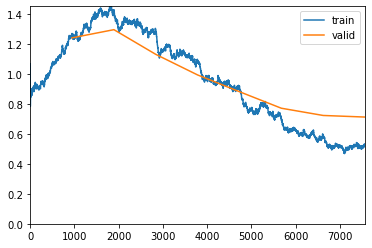

PosixPath('/kaggle/working/food-101-ResNet50-v1-unfreezed.pth')

In [17]:
learn.fit_one_cycle(8, slice(1e-4,lr/5))
learn.save('food-101-ResNet50-v1-unfreezed', return_path=True)

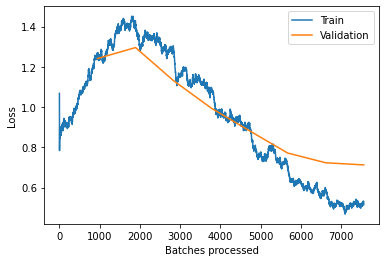

In [18]:
# Shows the changing to Loss along epochs
learn.recorder.plot_losses()

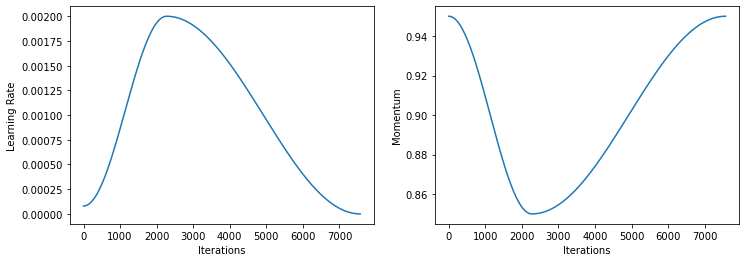

In [19]:
# Show lr and momentum change along epochs
learn.recorder.plot_lr(show_moms=True)

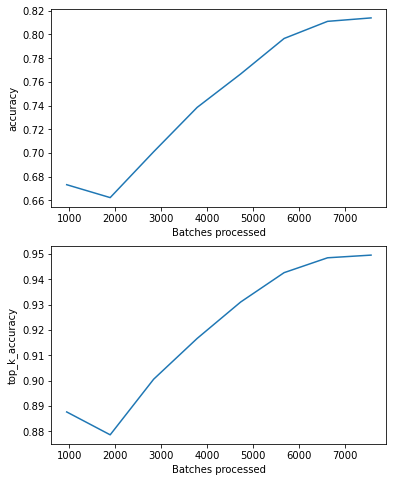

In [20]:
# Show Top-1 and Top-5 accuracy along epochs
learn.recorder.plot_metrics()

## Fine Tuning Model

In this section I tried to change image resolution to 512X512 so the model can learn more details about each images and give higher accuracy, however my kernel died during the process and I had to stop here.

In [21]:

bs_512 = int(bs/2)
train_data_512 = (ImageList.from_df(df=train_df,path=path_images, cols=1)\
                            .split_by_rand_pct(0.2)\
                            .label_from_df(cols=0)\
                            .transform(random_tfms, size=512)\
                            .databunch(bs=bs_512)\
                            .normalize(imagenet_stats))

print(train_data_512)

ImageDataBunch;

Train: LabelList (60600 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
apple_pie,apple_pie,apple_pie,apple_pie,apple_pie
Path: ../input/food-101/food-101/food-101/images;

Valid: LabelList (15150 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
strawberry_shortcake,oysters,lasagna,falafel,chocolate_mousse
Path: ../input/food-101/food-101/food-101/images;

Test: None


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


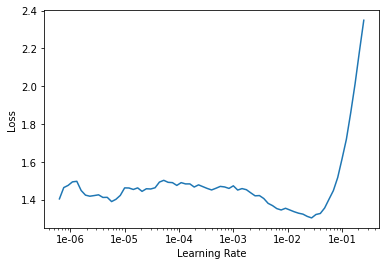

In [28]:

learn = cnn_learner(train_data_512, models.resnet50, metrics=[accuracy, partial(top_k_accuracy, k=5)], callback_fns=ShowGraph)

#change the output directory to the current working directory
learn.model_dir = os.getcwd()
learn.path = Path(os.getcwd())

learn.load('food-101-ResNet50-v1-unfreezed')
learn.lr_find()
learn.recorder.plot()

In [27]:
learn.unfreeze()
learn.fit_one_cycle(10, max_lr=slice(1e-6, 1e-2))
learn.save('food-101-ResNet50-512', return_path=True)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time


KeyboardInterrupt: 